In [1]:

import matplotlib.pyplot as plt

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

In [2]:
from __future__ import annotations

import sqlite3
from datetime import date

import pandas as pd

import repository.deepsearch as ds
from repository import get_day_chart, get_bussness_months
from repository.maria import corp

con = sqlite3.connect("../.out/analysis.db")
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' and name = 'layer1'")

if len(cursor.fetchall()) > 0:
    df = pd.read_sql("select * from layer1", con)
else:
    df = pd.DataFrame()
    from_date, to_date = date(2001, 4, 1), date(2022, 10, 31)
    prev_date = None
    for this_date in get_bussness_months(from_date, to_date):
        print(this_date)
        if prev_date is None:
            prev_date = this_date
            continue

        before = get_day_chart(prev_date)
        before = before[before['vol'] != 0]  # 거래량 미확인 종목 제외
        before = before[before['cap'] != 0]  # 시가총액 미확인 종목 제외
        # 매도일 주가데이터 조회
        after = get_day_chart(this_date)

        before_only = before.merge(after, how="outer", left_index=True, right_index=True).drop(after.index)
        if len(before_only) > 0:  # 상장폐지?
            pass

        # 팩터 계산
        this_df = before['close'].to_frame("before_close")
        this_df = this_df.join(after['close'].to_frame('after_close'))
        this_df = this_df.join((this_df["after_close"] / this_df["before_close"] - 1).to_frame("revenue"))
        this_df = this_df.join(before['cap'].to_frame('before_cap'))
        this_df = this_df.join(after['cap'].to_frame('after_cap'))
        this_df = this_df.join(pd.Series([prev_date] * len(before.index), index=before.index).to_frame("before_date"))
        this_df = this_df.join(pd.Series([this_date] * len(after.index), index=after.index).to_frame("after_date"))

        this_df = this_df.join(ds.load_and("매출총이익", prev_date.year, prev_date.month, 4, sum))
        this_df = this_df.join(ds.load_and("영업이익", prev_date.year, prev_date.month, 4, sum))
        this_df = this_df.join(ds.load_and("당기순이익", prev_date.year, prev_date.month, 4, sum))
        this_df = this_df.join(ds.load_one("자산", prev_date.year, prev_date.month))
        this_df = this_df.join(ds.load_one("자본", prev_date.year, prev_date.month))
        this_df['name'] = [corp.get_name(code) for code in this_df.index]

        df = pd.concat([df, this_df])
        prev_date = this_date

        df.to_sql("layer1", con, if_exists="replace")
        con.commit()

con.close()

df = df[df["after_date"].notnull()]
df = df.dropna()

col_map = {
    "매출총이익": "GP",
    "영업이익": "OP",
    "당기순이익": "NP",

    "자산": "A",
    "자본": "E",

    "영업활동으로인한현금흐름": "CFO",
    "투자활동으로인한현금흐름": "CFI",
    "재무활동으로인한현금흐름": "CFF"
}
df.columns = [col_map[col] if col in col_map else col for col in df.columns]

In [24]:
from typing import *
from analysis.sub import calc_factor
from multiprocessing import Pool

profit_kinds = [
    "GP",
    # "OP",
    # "NP"
]
base_kinds = [
    "E",
    "A"
]
profit_weights = [
    0.1,
    0.125,
    0.15,
    0.175,
    0.2,
    0.225,
    0.25
]
base_weights = [
    0.1,
    0.125,
    0.15,
    0.175,
    0.2,
    0.225,
    0.25
]

def combine(l1, l2) -> Iterable[Tuple[int, int]]:
    for i_l1 in l1:
        for i_l2 in l2:
            yield i_l1, i_l2


params_set = []

# fixme: df 사용하지 말고, db에서 새로 꺼내오자
for pk, pw in combine(profit_kinds, profit_weights):
    for bk, bw in combine(base_kinds, base_weights):
        params_set.append((df, pk, pw, bk, bw))

tasks = []
results = []
max_revenue: Tuple[str, float, list] = ("", 0, [])
with Pool(6) as p:
    for params in params_set:
        tasks.append(p.apply_async(calc_factor, params))

    seq, total = 1, len(params_set)
    for task in tasks:
        result = task.get()
        params = result[0]
        revenue_by_rank = result[1]
        revenue = sum(revenue_by_rank[:10]) / 10
        benchmark = sum(revenue_by_rank) / len(revenue_by_rank)
        if revenue > max_revenue[1]:
            max_revenue = (",".join([str(e) for e in params]), revenue, revenue_by_rank)

        print(",".join([f"{seq}/{total}", *[str(e) for e in params], str(revenue), str(benchmark)]))
        seq += 1

max_revenue

1/98,GP,0.1,E,0.1,0.06585712402933987,0.007527976948437498
2/98,GP,0.1,E,0.125,0.06762494102445102,0.007460516662772412
3/98,GP,0.1,E,0.15,0.06879662386421445,0.00746266923304037
4/98,GP,0.1,E,0.175,0.06868245954363314,0.00748426796233861
5/98,GP,0.1,E,0.2,0.06953533187627384,0.007488398470975808
6/98,GP,0.1,E,0.225,0.068860988319255,0.00749965140972517
7/98,GP,0.1,E,0.25,0.06706362140469144,0.0075164665978415725
8/98,GP,0.1,A,0.1,0.07099265861002345,0.0074253688431571065
9/98,GP,0.1,A,0.125,0.07350892587658245,0.0074542900925204875
10/98,GP,0.1,A,0.15,0.07491248461876542,0.007478823553301708
11/98,GP,0.1,A,0.175,0.07447694736185803,0.007498805527941857
12/98,GP,0.1,A,0.2,0.07303019003318162,0.007504908366892951
13/98,GP,0.1,A,0.225,0.07315546363133699,0.0075206056940773395
14/98,GP,0.1,A,0.25,0.07254694857839526,0.007530614001423887
15/98,GP,0.125,E,0.1,0.06691437827103527,0.007505129699383921
16/98,GP,0.125,E,0.125,0.06752589370963265,0.0075172500801069485
17/98,GP,0.125,E,0.15,0.066

('GP,0.1,A,0.15',
 0.07491248461876542,
 [0.07966136039349524,
  0.12981064127271763,
  0.04153604082419837,
  0.08134667584328634,
  0.07519278026355478,
  0.06464661590392119,
  0.04751874983320331,
  0.07969036008722193,
  0.07485696348697066,
  0.07486465827908464,
  0.0375792458929162,
  0.08153157524020926,
  0.01835385724217937,
  0.03869516627267318,
  0.03455071072089234,
  0.052194763399416616,
  0.035301524350016454,
  0.06542626845646717,
  0.023514081918439803,
  0.04690374496425793,
  0.06583003684828015,
  0.04422307649295677,
  0.029294461474421024,
  0.05219293512067175,
  0.02932066226967386,
  0.021641164435006063,
  0.030658160886399288,
  0.035056603422240734,
  0.05738806805004946,
  0.029234162023455627,
  0.07102989604754134,
  0.04319663126741117,
  0.024323163129595024,
  0.051379789898703385,
  0.05176645654848673,
  0.02770949475026947,
  0.05756233236394301,
  0.059882726933227416,
  0.036674651570955744,
  0.024981223146115714,
  0.058349279047307426,
  0.

GP,0.1,A,0.15 0.07491248461876542


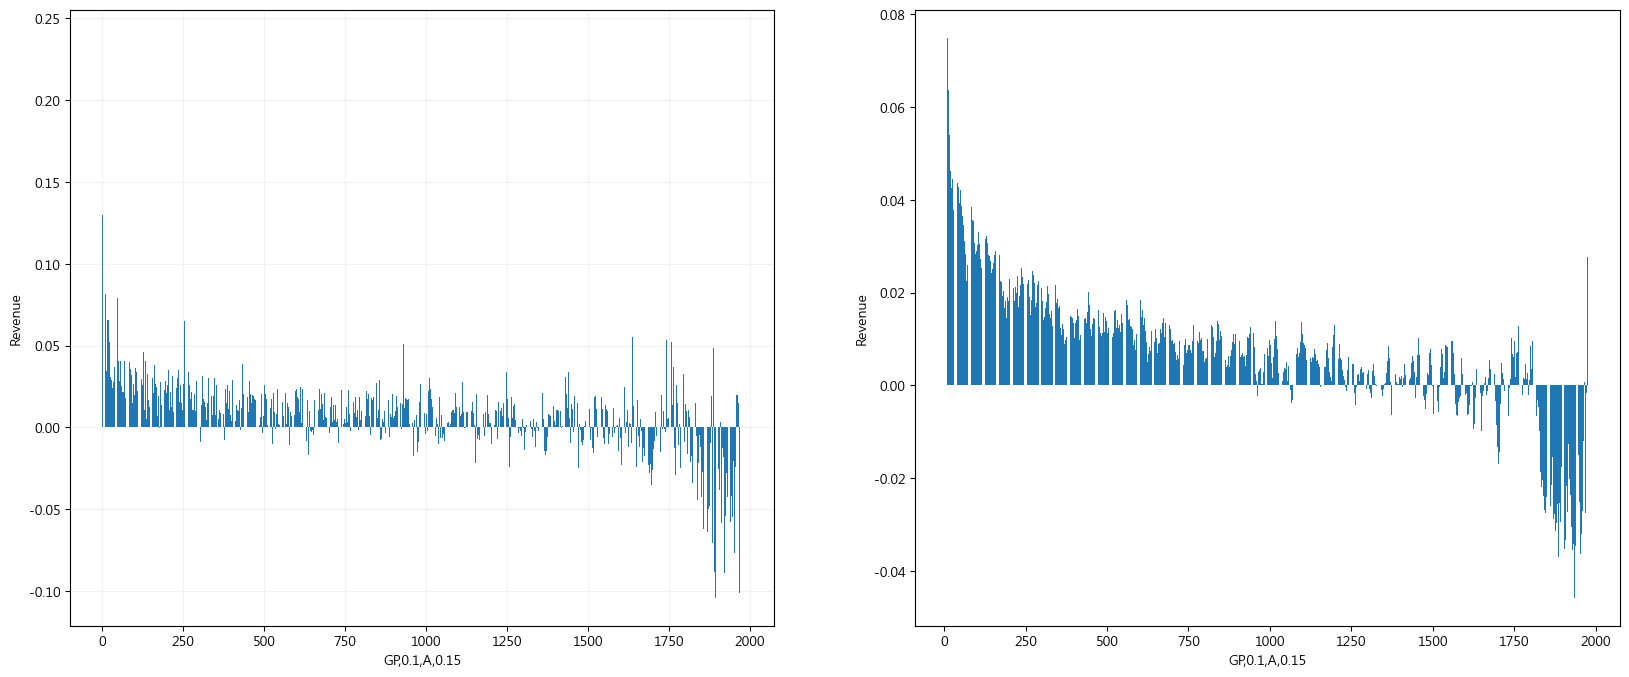

In [21]:
print(max_revenue[0], max_revenue[1])
x_label, y_label = max_revenue[0], "Revenue"
y = max_revenue[2]
x = [rank + 1 for rank in range(len(y))]
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.bar(x, y)
plt.subplot(1, 2, 2)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.bar(x, pd.Series(y).rolling(10).mean())
plt.show()